1. Для реализованной модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.

In [1]:
from sklearn.tree import DecisionTreeRegressor

from sklearn import model_selection
import numpy as np

In [2]:
from sklearn.datasets import load_diabetes

In [3]:
X, y = load_diabetes(return_X_y=True)

In [4]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

In [5]:
def gb_predict(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
    return np.array([sum([eta* coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])

In [6]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

In [7]:
def bias(y, z):
    return (y - z)

In [8]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        # базовый алгоритм
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, bias(y_train, target))
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [9]:
# Число деревьев в ансамбле
n_trees = 10

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth = 3

# Шаг
eta = 1

In [10]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta):
    train_prediction = gb_predict(X_train, trees, coefs, eta)
    train_err = mean_squared_error(y_train, train_prediction)
    test_prediction = gb_predict(X_test, trees, coefs, eta)
    test_err = mean_squared_error(y_test, test_prediction)
    return train_err, test_err


In [11]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [12]:
depth = list(range(1,11))
n_trees = 50
coefs = [1] * n_trees
train_errors=[]
test_errors = []

for d in depth:
    trees = gb_fit(n_trees, d, X_train, X_test, y_train, y_test, coefs, eta)[0]
    train_err, test_err = evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)
    train_errors.append(train_err)
    test_errors.append(test_err)

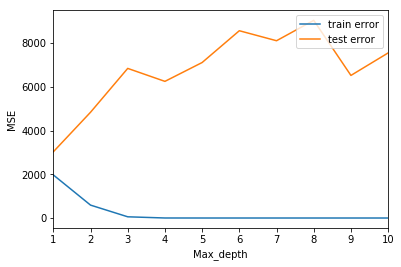

In [13]:
plt.xlabel('Max_depth')
plt.ylabel('MSE')
plt.xlim(1, max(depth))
plt.plot((depth), train_errors, label='train error')
plt.plot((depth), test_errors, label='test error')
plt.legend(loc='upper right')
plt.show()

In [14]:
num_trees = [10,20,30,40,50,60]
max_depth = 3
train_errors=[]
test_errors = []

for num in num_trees:
    coefs = [1] * num
    trees = gb_fit(num, max_depth, X_train, X_test, y_train, y_test, coefs, eta)[0]
    train_err, test_err = evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)    
    train_errors.append(train_err)
    test_errors.append(test_err)

print(num_trees,train_errors, test_errors)

[10, 20, 30, 40, 50, 60] [1200.127225482916, 508.3039729020279, 222.89420173646687, 119.37232610448358, 55.272968329190476, 22.50225877376482] [5205.622947943337, 5947.075461612364, 6172.298983025333, 6448.263903378139, 6843.936284931087, 6630.374429630712]


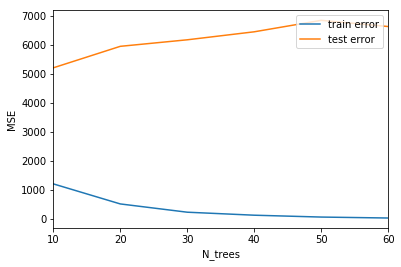

In [15]:
plt.xlabel('N_trees')
plt.ylabel('MSE')
plt.xlim(min(num_trees), max(num_trees))
plt.plot((num_trees), train_errors, label='train error')
plt.plot((num_trees), test_errors, label='test error')
plt.legend(loc='upper right')
plt.show()

С увеличением количества деревьев в ансамбле и максимальной глубины деревьев, ошибка на обучающей выборке падает, а на тестовой растет, что позволяет сделать выводы о переобучении

2*. Модифицировать реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. Сравнить на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.

In [16]:
import random

In [17]:
def get_subsample(len_sample,data,labels):
    
    sample_indexes = [i for i in range(len_sample)]
    
    len_subsample = int(0.5 * len_sample)
    subsample = []
    
    random.shuffle(sample_indexes)
    subsample = sample_indexes[0:len_subsample].copy()
    sample_data = np.zeros((len_subsample, X_train.shape[1])) 
    sample_labels = np.zeros(len_subsample,)    
    
    for j in range(len_subsample):
        sample_data[j] = data[subsample[j]]
        sample_labels[j] = labels[subsample[j]]

    return sample_data, sample_labels

In [18]:
sample_data, sample_labels = get_subsample(X_train.shape[0],X_train,y_train)
sample_data.shape

(165, 10)

In [19]:
sample_labels.shape

(165,)

In [20]:
def stochastic_gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta,subsample_size):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        # базовый алгоритм
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
        
        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на случайной подвыборке
            
            X_subsample, y_subsample = get_subsample(subsample_size,X_train,y_train)
            tree.fit(X_subsample, y_subsample)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы для подвыборки, на которой будем олбучать следующее дерево
            X_subsample, y_subsample = get_subsample(subsample_size,X_train,y_train)
            target = gb_predict(X_subsample, trees, coefs, eta)
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_subsample, bias(y_subsample, target))
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [21]:
# Число деревьев в ансамбле
n_trees = 60

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth = 3

# Шаг
eta = 1

subsample_size = X_train.shape[0]

trees, train_errors, test_errors = stochastic_gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta,
                                                     subsample_size)

In [22]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [23]:
def get_error_plot(n_trees, train_err, test_err):
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(n_trees)), train_err, label='train error')
    plt.plot(list(range(n_trees)), test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

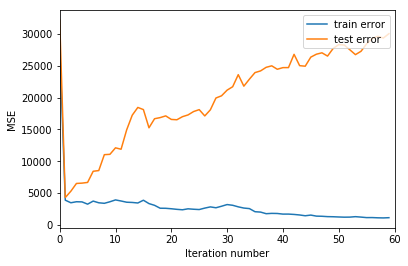

In [24]:
get_error_plot(n_trees, train_errors, test_errors)

Видим, что ошибка на тестовой выборке растет с ростом количества итераций, а на обучающей падает. 
Попробуем подобрать оптимальные значения шага и коэффициентов.

In [29]:
coefs = [0.001,0.005,0.01,0.05,0.1,0.5,1]
etas = [0.001,0.005,0.01,0.05,0.1,0.5,1]

In [30]:
n_trees = 60

max_depth = 3

subsample_size = X_train.shape[0]

best_coef = 0
best_eta = 0
best_err = np.inf
for coef in coefs:

    for eta in etas:
        trees, train_errors, test_errors = stochastic_gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, [coef] * n_trees, eta,
                                                     subsample_size)
        if min(test_errors) < best_err:
            best_err = min(test_errors)
            best_coef = coef
            best_eta = eta
print(best_err,best_coef, best_eta)

2902.953175715929 0.05 1


In [31]:
coefs = [0.05] * n_trees
eta = 1

subsample_size = X_train.shape[0]

trees, train_errors, test_errors = stochastic_gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta,
                                                     subsample_size)

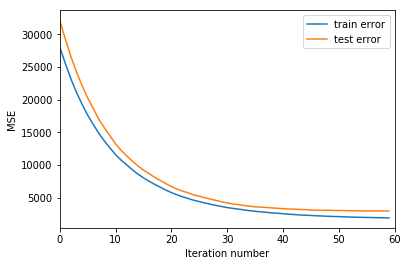

In [32]:
get_error_plot(n_trees, train_errors, test_errors)

Оптимальное значение коэффициентов - 0.05
Оптимальное значение для шага - 1